In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
%matplotlib inline
import theano.tensor as T
import scipy.stats as stats

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

C:\Users\aschroeder\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**3.1**

$$p(vampire\mid positive)=\frac{p(positive\mid vampire)*p(vampire)}{p(positive)}$$

$$p(positive)=p(positive\mid vampire)*p(vampire) + p(positive\mid mortal)*p(mortal)$$

In [2]:
#given to us from text
PrPV = 0.95
PrPM = 0.01
PrV = 0.001
PrP = PrPV * PrV + PrPM * (1 - PrV)

#Solution
PrVP = PrPV * PrV / PrP
PrVP

0.08683729433272395

**3.2 - 3.5**

Grid Approximation for the globe tossing problem

In [3]:
def  posterior_grid_approx(grid_points=100, success=6, tosses=9):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(5, grid_points)  # uniform
    #prior = (p_grid >= 0.5).astype(int)  # truncated
    #prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

In [4]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

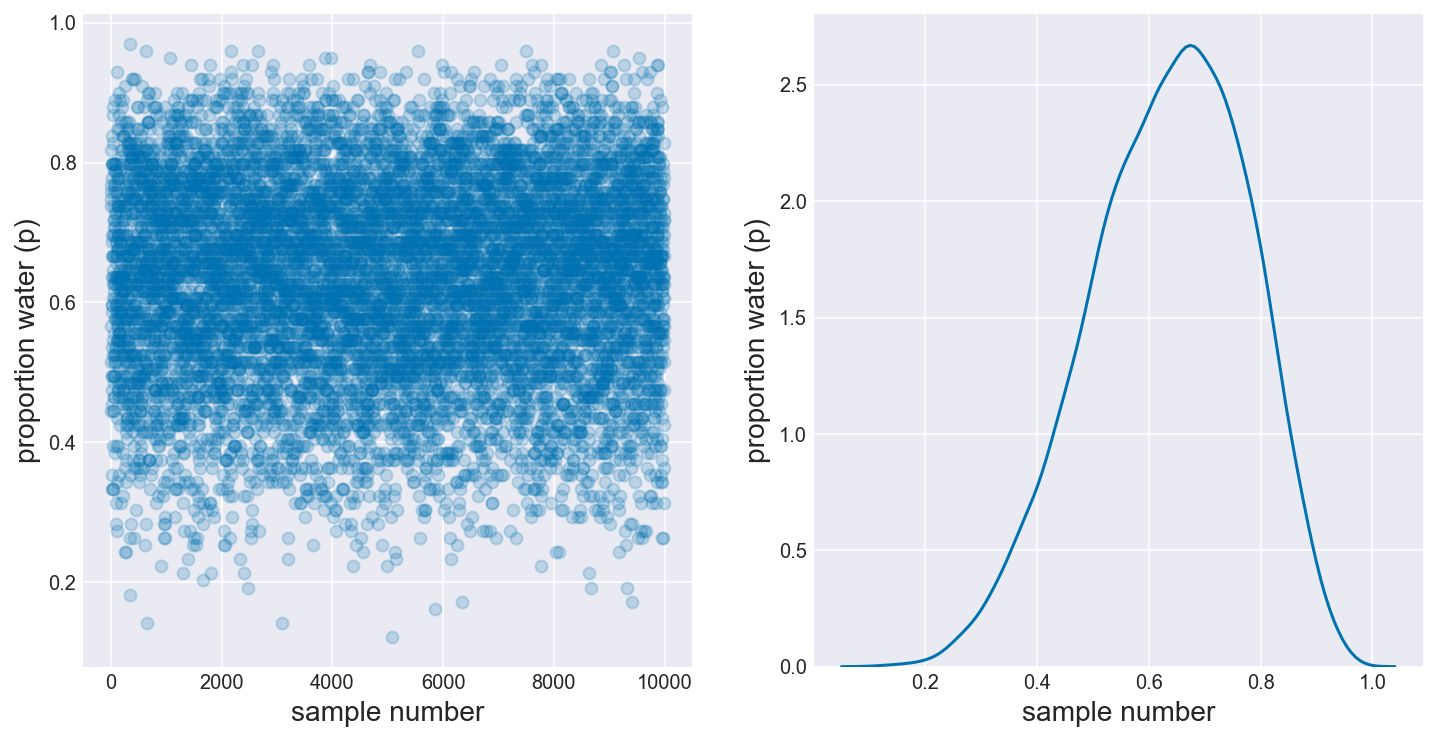

In [5]:
_, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
ax0.plot(samples, 'o', alpha=0.2)
ax0.set_xlabel('sample number', fontsize=14)
ax0.set_ylabel('proportion water (p)', fontsize=14)
sns.kdeplot(samples, ax=ax1)
ax1.set_xlabel('sample number', fontsize=14)
ax1.set_ylabel('proportion water (p)', fontsize=14);

**3.6 **
* Interval of Defined Boundaries (using grid approximation)

In [6]:
sum(posterior[ p_grid < 0.5 ])
# this means that 17% of the posterior probability lies under 50%

0.1718331311074748

**3.7** 
* Interval of Defined Boundaries (using samples from the posterior)

In [1]:
sum(samples<0.5)/1e4

NameError: name 'samples' is not defined

**3.8**
* How much of the posterior probability lies between 0.5 and 0.75

In [8]:
sum((samples>0.5)&(samples<0.75))/1e4
# which means that roughly 60% of the posterior probability lies between 0.5 and 0.75

0.6041

**3.9**
* Interval of Defind Mass

In [9]:
np.percentile(samples,80)
# samples below the 80% quartile are below 0.75

0.7575757575757577

**3.10**

In [10]:
np.percentile(samples, [10,90])
# this mid 80 percentile region, between the 10th and 90th percentile

array([0.44444444, 0.80808081])

**3.11**

* 3 waters in 3 tosses with uniform prior

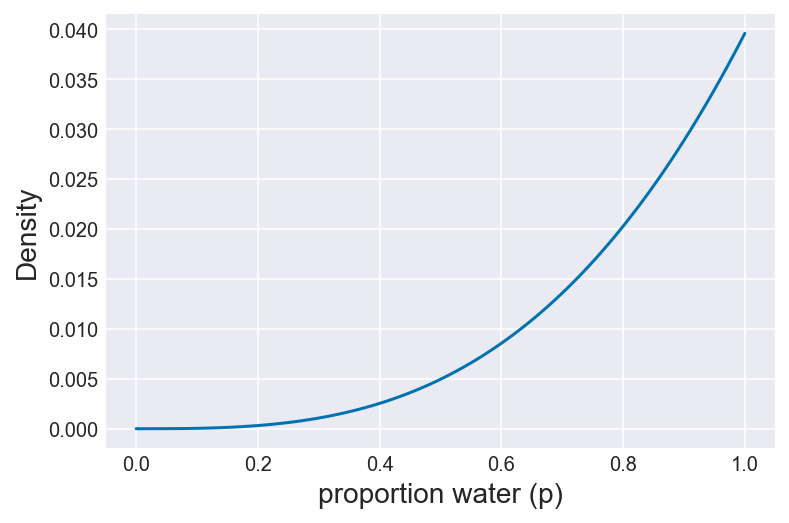

In [11]:
p_grid, posterior = posterior_grid_approx(success=3, tosses=3)
plt.plot(p_grid, posterior)
plt.xlabel('proportion water (p)', fontsize=14)
plt.ylabel('Density', fontsize=14);

**3.12**
* 50% percentile confidence interval 

In [23]:
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)
print("50% percentile confidence interval:")
np.percentile(samples, [25, 75])

50% percentile confidence interval:


array([0.71717172, 0.93939394])

**3.13**
* The above provides 25% of the probability mass above and below the interval. But this ends up excluding the most probable parameter values that are near `p=1`. In order to get the 50% highest posterior density interval, we can use pymc3's 'hdp' below

In [27]:
print(pm.hpd(samples, alpha=0.5)) # The HPD is the minimum width Bayesian credible interval (BCI)
print("This represents the densest interval in which 50% of the probability mass is located")

[0.84848485 1.        ]
This represents the densest interval in which 50% of the probability mass is located


In most cases, the hpd and the np.percentile confidence interval are similar, especially when the distribution is normal. But when the poseteior probability is highly skewed, these will not be similar

* **Ojo!** if the choice of interval type makes a big difference, we should not use intervals to summarize the posterior. Instead, we should plot the entire posterior distribution. 

**3.14**
* The MAP (maximum a posteriori), using the grid approximation

In [29]:
p_grid[posterior == max(posterior)]

array([1.])

**3.15**
* MAP, using samples from posterior

In [32]:
stats.mode(samples)[0]

array([1.])

**3.16**

In [35]:
print(np.mean(samples))
print(np.median(samples))

0.804678787878788
0.8484848484848485


**3.17**
* compute the weighted average loss, where each loss is weighted by its corresponding posterior probability

In [47]:
sum(posterior * abs(0.5 - p_grid))

0.31626874808692995

**3.18 & 3.19**
* compute the parameter values that minimize loss

In [76]:
loss = [sum(posterior * abs(p - p_grid)) for p in p_grid]
p_grid[loss == min(loss)]

array([0.84848485])

**3.20**
* likelihood of binomial distribution:
$$Pr(w\mid n,p) = \frac {n!}{w!(n-w)!}p^w(1-p)^{n-w}$$

Knowing that the proportation of water on earth is ~ 0.7, with two tosses of the globe, there are three possible outcomes: 0 waters, 1 water, 2 waters.

In [105]:
print(stats.binom.pmf(range(3), n=2, p=0.7))
print("\nMeaning there is a 9% cahnce that after 2 tosses of the globe, water will come up 0 times. There is a 42% chance\
that after 2 tosses, water will come up 1 time, etc.")

[0.09 0.42 0.49]

Meaning there is a 9% cahnce that after 2 tosses of the globe, water will come up 0 times. There is a 42% chancethat after 2 tosses, water will come up 1 time, etc.


**3.21**
* Instead of giving the formula all the possible outcomes of water and computing probabilities, we can simulate one observation and randomly generate (based on p=0.7) the amount of times water might appear on our thumb when globe lands:

In [102]:
stats.binom.rvs(n=2, p=0.7, size=1)

array([2])

**3.22**
* Let's simulate 10 observations

In [104]:
stats.binom.rvs(n=2, p=0.7, size=10)

array([1, 2, 1, 1, 1, 2, 1, 1, 1, 2])

**3.23**
* Let's simulate 100,000 observations for every 2 tosses and see if our probabilities of water landing on our thumb (in code 3.20) are true for large simulations. Theoretically, the larger the number of observations, the more likely it is that the expected parameter value will be 'true'  

In [120]:
dummy_w = stats.binom.rvs(n=2, p=0.7, size=int(1e5))
# computer the mean of all the times where dummy_w==0 waters then dummy_w==1 water then dummy_w==2 waters
print([(dummy_w == i).mean() for i in range(3)])    
print("\nResults are pretty similar to [0.09 0.42 0.49]")

[0.08966, 0.41976, 0.49058]

Results are pretty similar to [0.09 0.42 0.49]


**3.24**

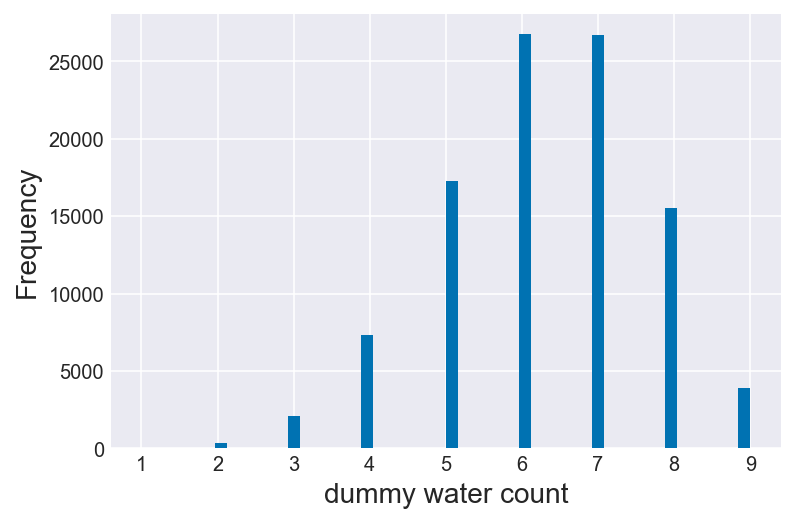

In [135]:
"""Using 9 tosses"""
dummy_w = stats.binom.rvs(n=9, p=0.7, size=int(1e5))
plt.hist(dummy_w, bins=50)
plt.xlabel('dummy water count', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

**3.25**

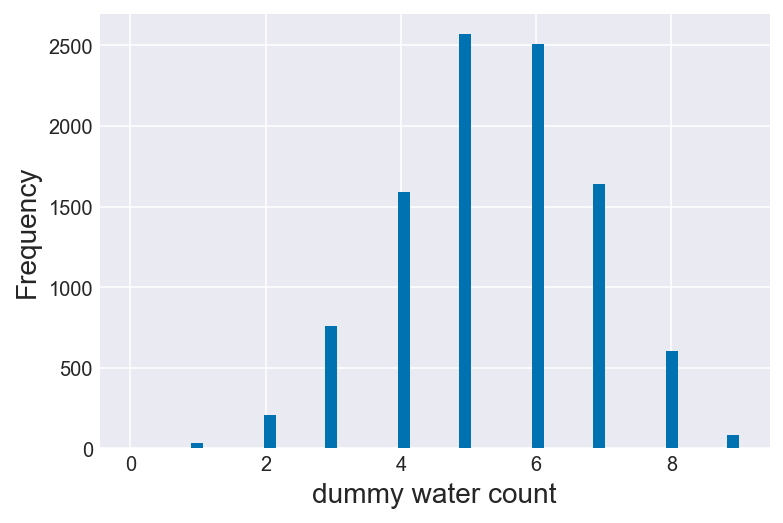

In [137]:
"""9 tosses and 60% probability"""
dummy_w = stats.binom.rvs(n=9, p=0.6, size=int(1e4))
plt.hist(dummy_w, bins=50)
plt.xlabel('dummy water count', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

**3.26**

Let's simulate our model predictions by simulating observations of randomly-generated binomial variables, while using the sampled parameters of the posterior disribution (in code 3.12) as the probability of the binomial; meaning, we are averaging over the posterior uncertainty.

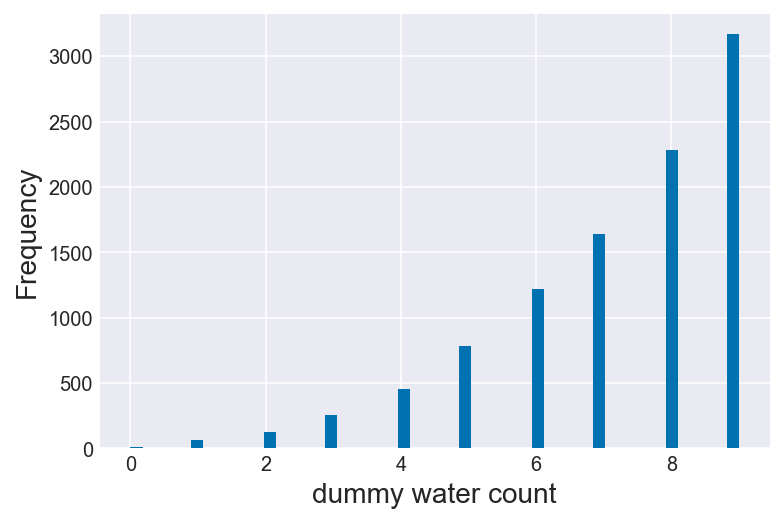

In [215]:
# For each sample value, a random binomial observation is created 
dummy_w = stats.binom.rvs(n=9, p=samples)
plt.hist(dummy_w, bins=50)
plt.xlabel('dummy water count', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

The samples of the posterior represented a probability close to 1 since the experiment in code 3.12 had 3 waters in 3 tosses. Therefore, using those sampled proportions as the 'p' in randomly generated bionmial variables where tosses = 9, we would get proportions of water that is close to 9. Similarily, if tosses = 20, we would get proportions of water that are close or equal to 20.